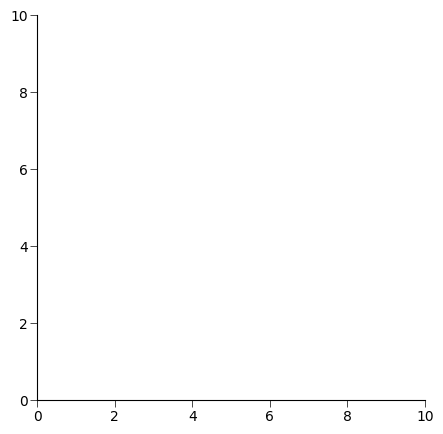

In [1]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1
##setting draw parameters

In [2]:
adata = cs.hf.read('/home/zhengtuo/songtao/weinreb_log2.h5ad')
adata.obs['index']=0
adata.obs['index']=adata.obs.index.astype(int)
adata.obs['time_info']=adata.obs['time_info'].astype(int)

In [3]:
###### from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from math import sqrt
from random import choice
from torch.utils.data  import Dataset, DataLoader
import pandas as pd
#from layers import SinkhornDistance
num_relations=8
len_geneExp=25289
len_embedding=256
learning_rate=0.0001
num_epoch=50
batchsize=512

criterion_rec = nn.MSELoss()
geneEnc=nn.Sequential(
        nn.Dropout(),
        nn.Linear(len_geneExp, 100),
        nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
         nn.Linear(100, 100),
                nn.ReLU(),
        nn.Linear(100, 100),
                nn.ReLU(),
        nn.Linear(100, len_embedding),
    )
    
geneDec = nn.Sequential(
    nn.Linear(len_embedding, len_geneExp),
)
genemap = nn.Sequential(
     #nn.Dropout(),
     nn.Linear(len_embedding, 100),
     nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k # 一般默认 Q=K
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        #定义线性变换函数
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out


device = torch.device("cuda")
device2 = torch.device("cuda")

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4)  # 输入通道数为1，输出通道数为6
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4)  # 输入通道数为6，输出通道数为16
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        #self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        # 输入x -> conv1 -> relu -> 2x2窗口的最大池化
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        # # 输入x -> conv2 -> relu -> 2x2窗口的最大池化
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        # # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        #x=self.dropout(x)
        x=self.fc1(x)
        return x
model=model()
optimizer = torch.optim.Adam(
    [{'params': geneEnc.parameters()},
    {'params': model.parameters()},
        {'params': geneDec.parameters()},
    #{'params': norelmodel.parameters()},
            {'params': genemap.parameters()}],
    lr=learning_rate)
from sklearn.metrics import confusion_matrix
TwoNets_path='/home/zhengtuo/songtao/weinreb.pth'
checkpoint = torch.load(TwoNets_path,map_location='cuda:1')
device2=torch.device("cuda:1")
model.load_state_dict(checkpoint['model'])
model.to(device2)
geneEnc.load_state_dict(checkpoint['geneEnc'])
geneEnc.to(device2)
model.eval()
geneEnc.eval()

genemap.load_state_dict(checkpoint['genemap'])
genemap.to(device2)
genemap.eval()



Sequential(
  (0): Linear(in_features=256, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=256, bias=True)
)

In [12]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from torch.autograd import Variable
import scanpy as sc
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt


mapembedding = []
all_embeddings = []
geneEnc.to(device)
genemap.to(device)

Embeddings_path = '/home/zhengtuo/newdata1-cnn.pth.txt' # txt dir to save cell embeddings

with torch.no_grad():
    for i in trange(adata.shape[0]):
        x = adata.X[i]
        geneExp = torch.tensor(x).to(device)
        geneExp=torch.reshape(geneExp,(1,25289))
        geneExp = geneExp.to(torch.float32)
        geneEmbedding = geneEnc(geneExp)
        mapEmbedding=genemap(geneEmbedding)
        mapEmbedding = mapEmbedding.cpu().detach().numpy()
        geneEmbedding = geneEmbedding.cpu().detach().numpy() # or any other data type
        all_embeddings.append(geneEmbedding)
        mapembedding.append(mapEmbedding)
    np.savez(Embeddings_path,all_embeddings)
all_embeddings=np.array(all_embeddings)
mapembedding=np.array(mapembedding)

adata.obsm['geneEnc']=all_embeddings
adata.obsm['genemap']=mapembedding
#adata.obsm['X_pca']=adata.obsm['X_pca'].cpu().numpy()



100%|███████████████████████████████████| 49116/49116 [00:42<00:00, 1164.20it/s]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


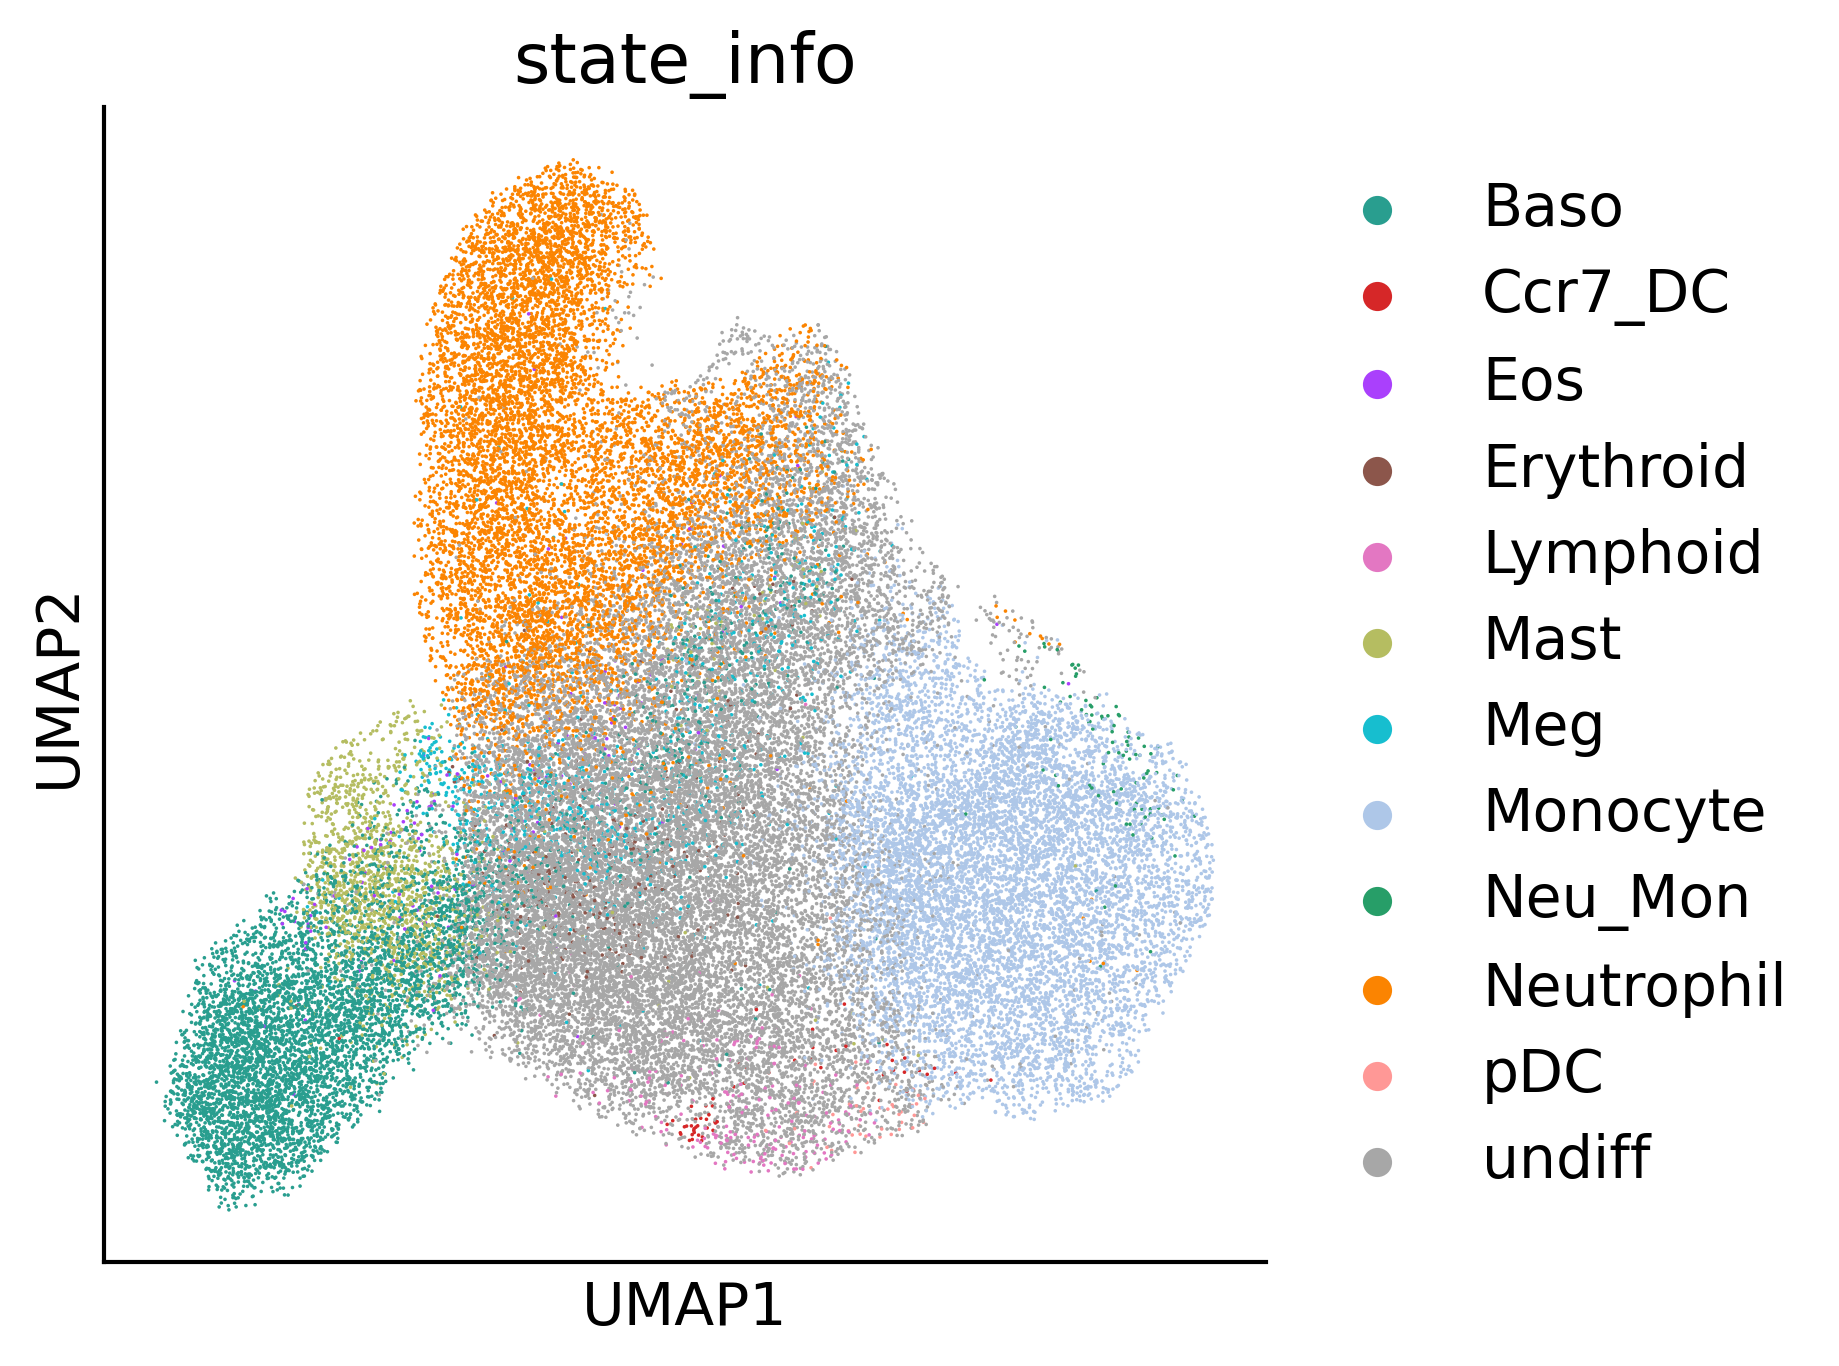

In [17]:
palette = dict(zip(sorted(np.unique(adata.obs['state_info'])), ['#299e8f', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#279e68', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2']))
palette['undiff'] = '#A7A7A7'
palette['Neutrophil'] = '#FB8401'
adata.uns['state_info_colors']=palette.values()
fig,ax=createFig()
fig.set_size_inches(5,5)
import torch
import umap
n= np.load("/home/zhengtuo/newdata1-cnn.pth.txt.npz")
n=torch.tensor(n['arr_0'])
n=torch.reshape(n,(49116,256))
adata.obsm["X_pca"] = n

cs.pp.get_X_emb(adata, n_neighbors=20, umap_min_dist=1)
sc.pl.umap(adata, color="state_info",ax=ax,palette=palette, s=3)


In [18]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor


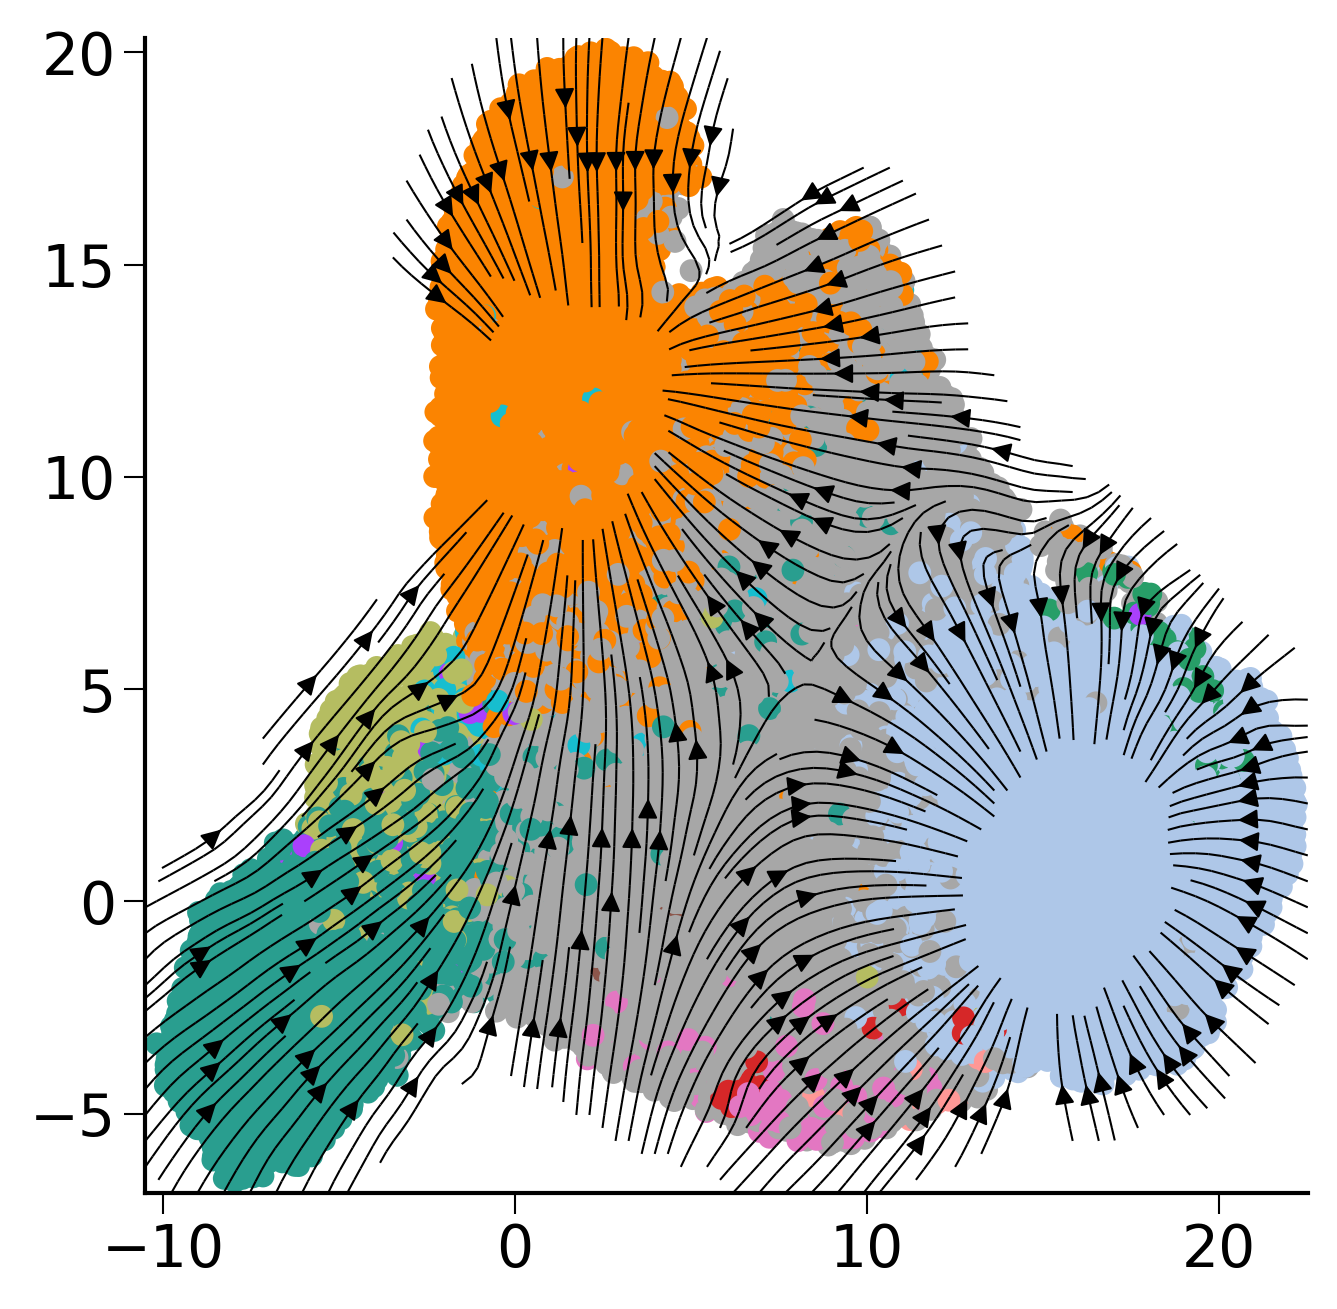

In [21]:
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
import tqdm
sc.pp.neighbors(adata)

X = adata.obsm['geneEnc'][:,0,:]
M = adata.obsm['genemap'][:,0,:]
N = adata.obsp['connectivities']
E = adata.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))
nn = NearestNeighbors(n_neighbors=20)
nn.fit(X)
dE = []
for i in tqdm.trange(N.shape[0]):

    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))
dE = np.vstack(dE)
gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata, 'state_info')
ax.scatter(E[:,0],E[:,1],s=30, linewidths=0,c=list(map(lambda x: palette[x], adata.obs['state_info'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 3,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)


In [4]:
traincell1=np.loadtxt('/home/zhengtuo/songtao/2traincell1.txt')
traincell2=np.loadtxt('/home/zhengtuo/songtao/2traincell2.txt')
testcell1=np.loadtxt('/home/zhengtuo/songtao/2testcell1.txt')
testcell2=np.loadtxt('/home/zhengtuo/songtao/2testcell2.txt')
train_rel=np.loadtxt('/home/zhengtuo/songtao/2trainrel.txt',dtype=int)
test_rel=np.loadtxt('/home/zhengtuo/songtao/2testrel.txt',dtype=int)

In [5]:
dic_true={}
for i in range((adata.shape[0])):
    if(adata.obs['NeuMon_fate_bias'][i]>0.5):
        dic_true[adata.obs['index'][i]]=1
    elif(adata.obs['NeuMon_fate_bias'][i]<0.5):
        dic_true[adata.obs['index'][i]]=0
    else:
        dic_true[adata.obs['index'][i]]=2
all_cell1=list(traincell1)+list(testcell1)
all_cell2=list(traincell2)+list(testcell2)
##### import torch
# n= np.load("/home/songtao/CNNWithMap-12rel.pth.txt.npz")
# n=torch.tensor(n['arr_0'])
# n=torch.reshape(n,(130887,256))
# adata.obsm["X_pca"] = n
#dic2={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:10,10:9,11:0,12:1,13:2,14:3,15:4,16:5,17:6,18:7,19:8,20:10,21:9}
from torch.utils.data import Dataset, DataLoader
class UndiffDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(all_cell1))[idx])
        gene=adata.X[i]
        gene=torch.tensor(gene)
        true_fate=dic_true[i]
        #genetype=dic1[genetype]
        true_fate=torch.tensor(true_fate)

        return gene,true_fate

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
class otherDataset(Dataset):
    # 构造器初始化方法
    def __init__(self,length):
        self.length=length

    # 重写getitem方法用于通过idx获取数据内容
    def __getitem__(self, idx):
        i=int(list(set(all_cell2))[idx])
        gene=adata.X[i]
        gene=torch.tensor(gene)
        genetype=adata.obs['state_info'][i]
        genetype=dic[genetype]
        genetype=torch.tensor(genetype)
        return gene,genetype

    # 重写len方法获取数据集大小
    def __len__(self):
        return self.length
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)


unidffdataset = UndiffDataset(len(list(set(all_cell1))))
otherdataset=otherDataset(len(list(set(all_cell2))))
Undiffdataloader = DataLoader(unidffdataset, batch_size=len(list(set(all_cell1))), num_workers=4, shuffle=False, drop_last=False)
otherdataloader=DataLoader(otherdataset, batch_size=1, num_workers=4, shuffle=False, drop_last=False)

In [7]:
true=0
cudaid = 'cuda:7'
dic={'Monocyte':0, 'Neutrophil':1, 'Lymphoid':2,'Mast':3, 'Ccr7_DC':4,
       'Baso':5, 'Eos':6}
device2 = torch.device(cudaid)
geneEnc.to(device2)
model.to(device2)
for i, onebatch1 in enumerate(Undiffdataloader):
    cell1=onebatch1[0].to(device2)
    cell1=geneEnc(cell1)
    hang=cell1.shape[0]
    true_labels=onebatch1[1]
    pre=torch.zeros(hang)
    pre_labels=torch.zeros((hang,7))
    print(i)
    for j, onebatch2 in enumerate(otherdataloader):
        print(j)
        cell2=onebatch2[0].to(device2)
        cell2=geneEnc(cell2)
        cell2=dup_rows(cell2.cpu().detach().numpy(), indx=0,num_dups=hang-1)
        cell2=torch.tensor(cell2).to(device2)
        genetype=onebatch2[1]
        geneEmbs = torch.cat((cell1, cell2), -1)
        geneEmbs=torch.reshape(geneEmbs,(geneEmbs.shape[0],1,geneEmbs.shape[1]))
        outputs = model(geneEmbs)
        outputs=torch.reshape(outputs,(hang,8))
        outputs=outputs.argmax(-1)

        for num in range(hang):
            if(int(outputs[num])!=7):
                pre_labels[num][int(outputs[num])]+=1
        del outputs,cell2,genetype,geneEmbs
        torch.cuda.empty_cache()
    matrix1=pre_labels
    pre_labels=np.argsort(-pre_labels)
    pre_labels=pre_labels.T[0]
    true+=np.count_nonzero(pre_labels==true_labels)
    del cell1
    torch.cuda.empty_cache()
 


In [8]:
true=0
pre_labels=np.loadtxt('/home/zhengtuo/songtao/matrixweinreb-2.2.txt')
true_labels=np.array(true_labels)
true+=np.count_nonzero(pre_labels==true_labels)
true/len(set(all_cell1))

0.8562073669849932

In [11]:
from cal_acc import cal_acc,cal_R
print('acc:',cal_acc(true_labels,pre_labels))
print('R:',cal_R(true_labels,pre_labels))
    
    

acc: 0.924572775486152
R: 0.8489282949191337


In [8]:
import DestinyNet
import sys
sys.argv=['']
del sys
args=DestinyNet.get_args()
DestinyNet.train(args)